In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [2]:
try:
    df = pd.read_csv("sp500_master.csv", parse_dates=['Date'])
    print(f"Datos cargados. Dimensiones: {df.shape}")
    print(f"Rango de fechas: {df['Date'].min()} a {df['Date'].max()}")
    print(f"Total de empresas: {df['Ticker'].nunique()}")
except FileNotFoundError:
    print("ERROR: Por favor, sube el archivo 'sp500_master.csv' al entorno.")

Datos cargados. Dimensiones: (1170126, 7)
Rango de fechas: 2016-02-17 00:00:00 a 2026-02-10 00:00:00
Total de empresas: 466



=== 1. ESTRUCTURA DE LOS DATOS ===
Dimensiones: 1170126 filas x 7 columnas
Total Empresas: 466
Periodo Temporal: 2016-02-17 hasta 2026-02-10

Estadísticas (con datos normalizados o sin normalizar según tu estado actual):
              Close        Volume        Return
count  1.170126e+06  1.170126e+06  1.170126e+06
mean   1.394823e-02  1.748012e-03  5.816570e-01
std    3.071422e-02  7.453237e-03  1.549572e-02
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    4.258501e-03  2.678904e-04  5.751198e-01
50%    7.973446e-03  5.690336e-04  5.819105e-01
75%    1.510905e-02  1.343676e-03  5.885888e-01
max    1.000000e+00  1.000000e+00  1.000000e+00
        Date Ticker     Close    Volume      High       Low    Return
0 2016-02-17      A  0.003455  0.001457  0.003757  0.003479  0.597103
1 2016-02-18      A  0.003392  0.000604  0.003740  0.003718  0.567649
2 2016-02-19      A  0.003415  0.000633  0.003704  0.003693  0.586298
3 2016-02-22      A  0.003470  0.000485  0.003763  0.003788  0.593

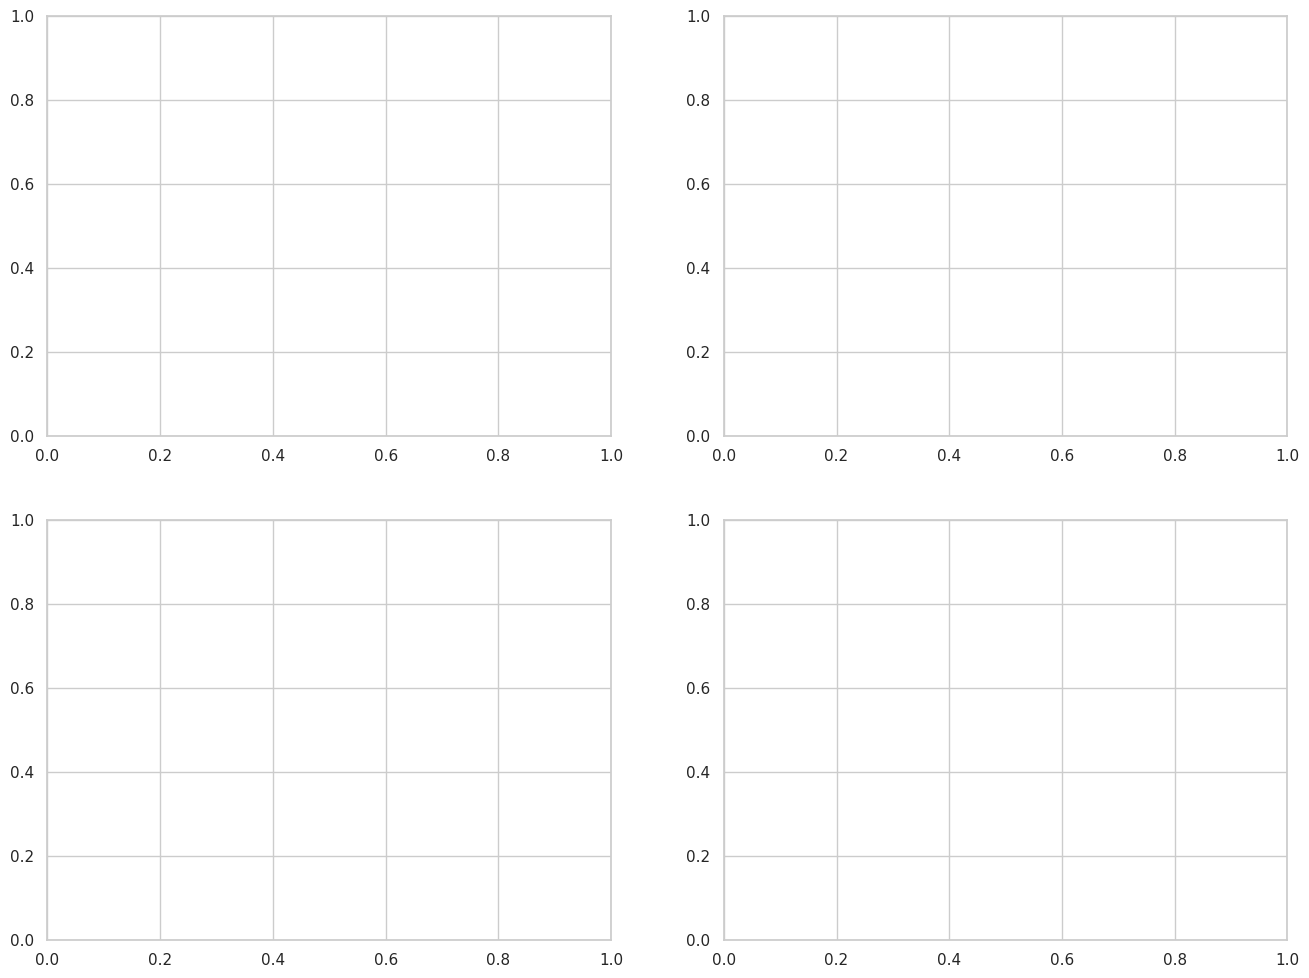

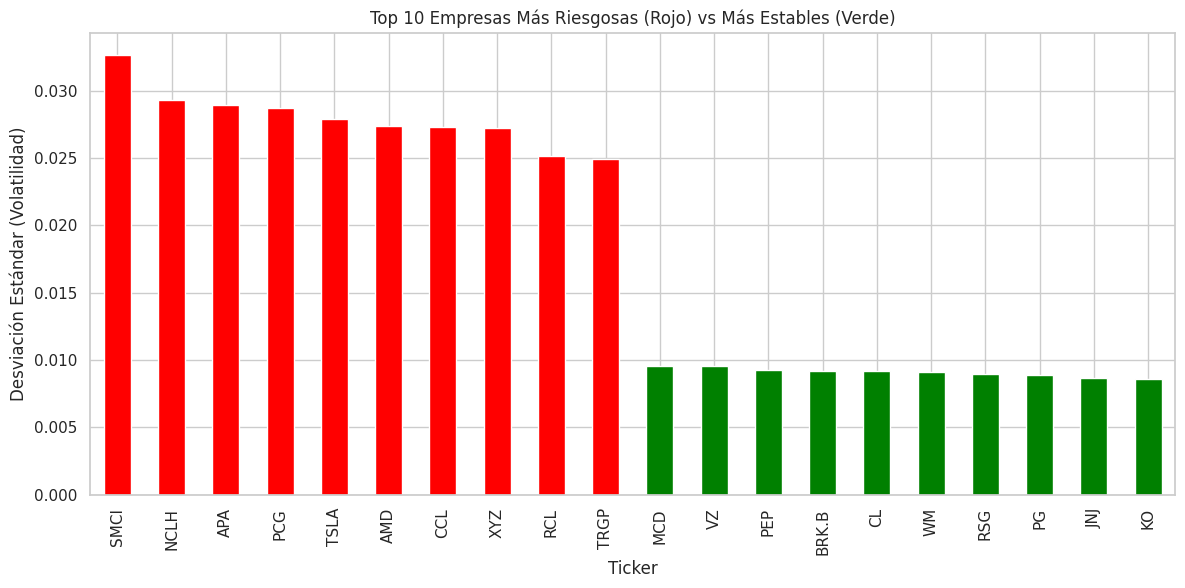

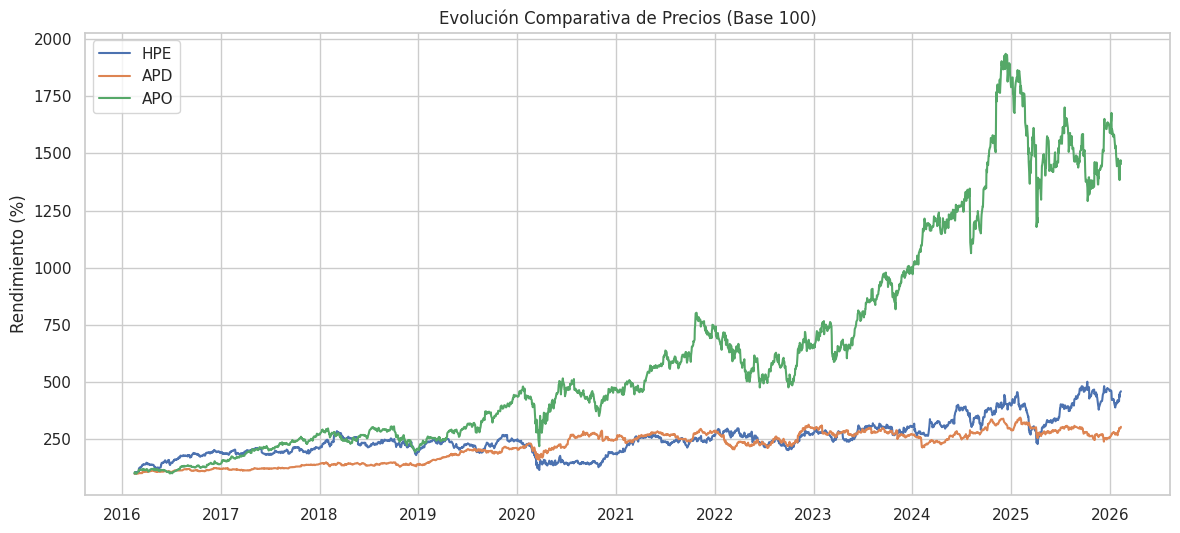


✅ EDA FINALIZADO.


In [5]:
# 1. RESUMEN ESTADÍSTICO
print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"Total Empresas: {df['Ticker'].nunique()}")
print(f"Periodo Temporal: {df['Date'].min().date()} hasta {df['Date'].max().date()}")
print(df[['Close', 'Volume', 'Return']].describe())
print(df.head(10))

# 2. VISUALIZACIÓN DE DISTRIBUCIONES
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# 3. ANÁLISIS COMPARATIVO (VOLATILIDAD)
# Calculamos la desviación estándar de los retornos por empresa (Riesgo)
volatility = df.groupby('Ticker')['Return'].std().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
# Top 10 más volátiles vs Top 10 más estables
top_volatile = volatility.head(10)
top_stable = volatility.tail(10)
combined = pd.concat([top_volatile, top_stable])

colors = ['red']*10 + ['green']*10
combined.plot(kind='bar', color=colors)
plt.title('Top 10 Empresas Más Riesgosas (Rojo) vs Más Estables (Verde)')
plt.ylabel('Desviación Estándar (Volatilidad)')
plt.xlabel('Ticker')
plt.show()

# 4. PRECIOS NORMALIZADOS (Tendencias)
# Elegimos 3 empresas aleatorias para ver cómo han evolucionado comparativamente
tickers_sample = np.random.choice(df['Ticker'].unique(), 3, replace=False)
plt.figure(figsize=(14, 6))

for ticker in tickers_sample:
    subset = df[df['Ticker'] == ticker].sort_values('Date')
    # Normalizamos a base 100 para comparar peras con peras
    price_base_100 = (subset['Close'] / subset['Close'].iloc[0]) * 100
    plt.plot(subset['Date'], price_base_100, label=ticker)

plt.title('Evolución Comparativa de Precios (Base 100)')
plt.ylabel('Rendimiento (%)')
plt.legend()
plt.show()

print("\n✅ EDA FINALIZADO.")

In [4]:
# PREPROCESAMIENTO PARA DEEP LEARNING

# 1. Normalización (0-1)
features = ['Close', 'Volume', 'High', 'Low', 'Return']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# 2. Función Optimizada para crear secuencias
def create_sequences_fast(df, seq_length=30):
    all_X = []
    all_y = []

    # Iteramos por empresa usando groupby (mucho más rápido)
    for ticker, group_data in df.groupby('Ticker'):
        data = group_data[features].values

        if len(data) > seq_length:
            # Ventana deslizante vectorizada
            num_samples = len(data) - seq_length
            indexer = np.arange(seq_length)[None, :] + np.arange(num_samples)[:, None]

            x_window = data[indexer]
            y_window = data[seq_length:, 4] # Target: Return

            all_X.append(x_window)
            all_y.append(y_window)

    return np.concatenate(all_X), np.concatenate(all_y)

# 3. Ejecución
SEQ_LENGTH = 30
print("Generando tensores X e y...")
X, y = create_sequences_fast(df, SEQ_LENGTH)

print(f"\n=== RESULTADO FINAL ===")
print(f"Dimensiones de X (Entrada): {X.shape} -> (Muestras, 30 días, 5 variables)")
print(f"Dimensiones de y (Salida):  {y.shape} -> (Muestras,)")

Generando tensores X e y...

=== RESULTADO FINAL ===
Dimensiones de X (Entrada): (1156146, 30, 5) -> (Muestras, 30 días, 5 variables)
Dimensiones de y (Salida):  (1156146,) -> (Muestras,)
